In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import os

import gcsfs
from tqdm import tqdm
import fsspec

import wrf

xr.set_options(display_style="html");
# xr.show_versions()

In [ ]:
from dask.distributed import Client, progress, LocalCluster
import numcodecs

cluster = LocalCluster()
cluster

In [ ]:
client = Client(cluster)

In [ ]:
numcodecs.blosc.use_threads = False

## dirs etc

In [2]:
gcsdir = '/Users/dporter/data/Antarctic/'
ampsdir = 'AMPS'
amps_ver = 'WRF_24'
domain = 'wrfout_d03_20161222_week'
filepattern = 'wrfout_*'

pattern = os.path.join(gcsdir, ampsdir, amps_ver, domain, filepattern)
print(pattern)

/Users/dporter/data/Antarctic/AMPS/WRF_24/wrfout_d03_20161222_week/wrfout_*


In [3]:
NCs = glob(pattern)
print(f"Total of {len(NCs)} wrf files.\n")
print(NCs[0])

Total of 56 wrf files.

/Users/dporter/data/Antarctic/AMPS/WRF_24/wrfout_d03_20161222_week/wrfout_d03_2016122512_f006.nc


In [4]:
NCs_urls = NCs

In [5]:
ds = xr.open_dataset(NCs_urls[0], engine='netcdf4', chunks={'south_north': 500, 'west_east': 270})

In [6]:
print(type(ds.T2.data))
print(ds.T2.chunks)

<class 'dask.array.core.Array'>
((1,), (500, 325), (270, 267))


In [7]:
ds.T2

<xarray.DataArray 'T2' (Time: 1, south_north: 825, west_east: 537)>
dask.array<open_dataset-7bf2007cc141ceec5fe0a794a899d4ebT2, shape=(1, 825, 537), dtype=float32, chunksize=(1, 500, 270), chunktype=numpy.ndarray>
Coordinates:
    XLAT     (Time, south_north, west_east) float32 dask.array<chunksize=(1, 500, 270), meta=np.ndarray>
    XLONG    (Time, south_north, west_east) float32 dask.array<chunksize=(1, 500, 270), meta=np.ndarray>
    XTIME    (Time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: Time, south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  TEMP at 2 M
    units:        K
    stagger:

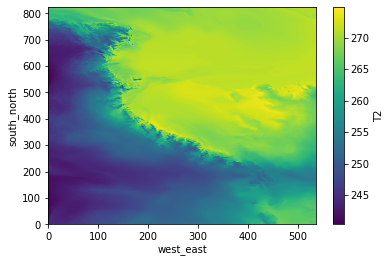

In [8]:
ds['T2'].mean(dim='Time').plot()

In [9]:
with  fsspec.open(NCs_urls[0], mode='rb')  as openfile:  
    ds = xr.open_dataset(openfile, engine='h5netcdf', 
                         chunks={'south_north': -1, 'west_east': -1, 'Time': 1})  # , decode_coords=False
    
for i in tqdm(range(1, len(NCs_urls))):  
    with  fsspec.open(NCs_urls[i], mode='rb')  as openfile:  
        temp = xr.open_dataset(openfile, engine='h5netcdf', 
                               chunks={'south_north': -1, 'west_east': -1, 'Time': 1})  
    ds = xr.concat([ds,temp],'Time')
    
ds.T2

100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


<xarray.DataArray 'T2' (Time: 56, south_north: 825, west_east: 537)>
dask.array<concatenate, shape=(56, 825, 537), dtype=float32, chunksize=(1, 825, 537), chunktype=numpy.ndarray>
Coordinates:
    XLAT     (Time, south_north, west_east) float32 dask.array<chunksize=(1, 825, 537), meta=np.ndarray>
    XLONG    (Time, south_north, west_east) float32 dask.array<chunksize=(1, 825, 537), meta=np.ndarray>
    XTIME    (Time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: Time, south_north, west_east
Attributes:
    FieldType:    [104]
    MemoryOrder:  XY 
    description:  TEMP at 2 M
    units:        K
    stagger:

In [11]:
print(ds.nbytes / 1e9)

94.89125268


## use raw wrf-python functions to do diagnostics (hopefully using Dask Delayed...)

In [12]:
nx = ds.dims['west_east']
ny = ds.dims['south_north']
dt, dx, dy = ds.DT, ds.DX, ds.DY
cen_lat, cen_lon = ds.CEN_LAT, ds.CEN_LON
truelat1, truelat2, STAND_LON = ds.TRUELAT1, ds.TRUELAT2, ds.STAND_LON
pole_lat, pole_lon = ds.POLE_LAT, ds.POLE_LON

In [15]:
cone = 1 # ???
uv   = wrf.uvmet(ds.U10, ds.V10, 
                 ds.XLONG.isel(Time=1), ds.XLAT.isel(Time=1), 
                 cen_lon, cone, meta=True, units='m s-1')

ValueError: seek of closed file

In [ ]:
# ds = xr.open_mfdataset(NCs_urls, engine='netcdf4', chunks={'Time': 1})

# ds = xr.open_mfdataset(NCs_urls, engine='netcdf4', parallel=True, concat_dim='Time',combine='by_coords')
# #                         chunks={'XLAT': -1})#, 'lat': 168, 'lon': 150}

def preprocessing(ds): 
    return ds.expand_dims(dim='Time')

ds = xr.open_mfdataset(NCs_urls, engine='netcdf4', parallel=True,
                      data_vars='minimal', coords='minimal', compat='override')#, preprocess = preprocessing)

# ds = xr.open_mfdataset(NCs_urls, engine='netcdf4', parallel=True,
#                        concat_dim="Time", data_vars='minimal', coords='minimal', compat='override')